In [1110]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [873]:
import re
import pandas as pd
from datetime import datetime 
import statistics
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import expon
import matplotlib.pyplot as plt
import scipy.stats as stats
import IPython.display 
from scipy.stats import gamma
from scipy.stats import norm

### Read the log file

In [1116]:

log_file_path = r"/Users/zoeyzhang/Downloads/mock-server.log"
#regex = '(<property name="(.*?)">(.*?)<\/property>)'


logs = pd.DataFrame({'ip': [], 'timestamp': [],'command': [], 'status': [], 'returned_ob': []})
with open(log_file_path, "r") as file:
    for line in file:
        line = line.strip('\n')
        ip = line.split(' ')[0]
        timestamp = re.search(r'\[[\s\S]*\]', line).group()
        command = re.search(r'\"[\s\S]*\"', line).group()
        status = line.split(' ')[-2]

        return_ob = line.split(' ')[-1]
        row = {'ip': ip, 'timestamp': timestamp,'command': command, 'status': status, 'returned_ob': return_ob}
        logs = logs.append(row,ignore_index=True)

In [1122]:
# the hour of the log files
logs['timestamp'].apply(lambda x: x[13:21]).min();
logs['timestamp'].apply(lambda x: x[13:21]).max();
print('The file contains logs generated at 18:00 2019-10-21')

The file contains logs generated at 18:00 2019-10-21


Columns: 
1. ip: IP address
2. timestamp: timestamp of the request 
3. command command of the request 
4. status: request status
5. returned_ob: the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-"


In [909]:
logs.head()

ip           timestamp  \
0   176.91.204.223 2019-10-21 18:00:00   
1   176.91.204.223 2019-10-21 18:00:01   
2   176.91.204.223 2019-10-21 18:00:02   
3  147.214.232.221 2019-10-21 18:00:02   
4   176.91.204.223 2019-10-21 18:00:03   

                                           command status  returned_ob  
0                      "POST /rest/login HTTP/1.1"    401           45  
1                      "POST /rest/login HTTP/1.1"    401           45  
2                      "POST /rest/login HTTP/1.1"    401           45  
3  "GET /rest/message?message_id=1218835 HTTP/1.1"    404           45  
4                      "POST /rest/login HTTP/1.1"    401           45

### Transfrom data type 

Transform column timestamp and transform returned_ob to numeric data type and replace '-' with 0 

In [905]:
logs['timestamp'] = logs['timestamp'].apply(lambda x: datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S'))

In [904]:
logs['returned_ob'] = logs['returned_ob'].apply(lambda x: 0 if x == '-' else x)
logs['returned_ob'] = pd.to_numeric(logs['returned_ob'])

### Summarize logs by IP 
Summarize logs by 1. the number of requests, 2.the average size of returned object, 3.the fraction of requests with no objects returned, let's call it bounce rate for now and 4. the time intervals between sessions

#### Why do we care about wait time between requests/time intervals
Suppose there is an IP that sent requests at 2019-10-21 18:00:15, 2019-10-21 18:00:30,2019-10-21 18:00:45, 2019-10-21 18:01:00. The IP made 80 requests and between each request, this IP waits exactly 15 seconds every time. There is strong pattern in this IP behavior. It is safe for us to tag the IP as anomaly. The list of time intervals between requests help us to identify the pattern of IP behavior. Robots tend to have more strong pattern in its behavior.Human behavior tends to have more varied time intervals, when they send to another request is not easily predictable. 

#### Interval variety ratio or standard deviation 
interval variety rate is used to measure how varied the list of time intervals are between requests. \
interval_variety_rate = number of unique intervals/total requests\
If an IP sends requests at 2019-10-21 18:00:15, 2019-10-21 18:00:30,2019-10-21 18:00:45, 2019-10-21 18:01:00. The number of unique intervals = 1 and total reuqests = 4 and therefore interval_variety_rate = 1/4 
The benefit of interval_variety_ratio is to measure how unpredictable that IP requests are. Standard deviation which also can measure variety, is affected by the value of time interval. For example,  an IP sends requests at 18:00:15,
18:01:15, 18:01:30, 18:02:30, 18:02:45. The list of intervals is [60, 15, 60, 15, 60, 15,...., 16,15]. There is strong pattern in the list however the variance could be also large compared to an IP with interval of which values are more close to each other like [1,2,1.5,3,4]. 

In [1025]:
# requests per IP in the hour 
request_counts = logs.groupby('ip')['timestamp'].count().reset_index(name = 'hits')

In [1026]:
# average size of objects returned in the hour 
avg_returned_ob = logs.groupby('ip')['returned_ob'].mean().reset_index(name = 'avg_returned_ob')

In [1027]:
# merge two tables 
log_summary_per_ip = pd.merge(avg_returned_ob, request_counts, how = 'right')

In [1028]:
# bouce rate per Ip
bounce_rate = logs.groupby('ip')['returned_ob'].apply(lambda x: len([i for i in x if i==0 ])/len(x)).\
reset_index(name='bounce_rate')

In [1029]:
# merge tables 
log_summary_per_ip = pd.merge(log_summary_per_ip, bounce_rate)

In [1031]:
def intervals_in_mins(alist):
    """
    Input the request timestamp series and obtain the duration between requests 
     an IP requests at 2019-10-21 18:00:00, 2019-10-21 18:00:01,2019-10-21 18:00:02
     the time interval between sessions in minutes will be [1, 1] 
    Output: time intervals between requests 
    """
    
    alist = list(alist)
    l = list()
    if(len(alist) > 1): 
        for i in range(len(alist)-1, 0, -1):
            minutes = (alist[i] - alist[i-1]).seconds/60
            l.append(minutes)
        return(l)

In [1032]:
# obtain the time intervals between requests for each IP    
ip_interval = logs.sort_values(['ip', 'timestamp']).groupby('ip')['timestamp'].\
apply(intervals_in_mins).\
reset_index(name = 'interval')

In [1033]:
#calculate the average length of time interval that an IP waits between requests 
ip_interval['avg_interval'] = ip_interval['interval'].apply(lambda x: sum(x)/len(x))
ip_interval['sd_interval'] = ip_interval['interval'].apply(lambda x: statistics.stdev(x))

In [1034]:
#merge to the summary table 
log_summary_per_ip = pd.merge(ip_interval, log_summary_per_ip).sort_values(['hits', 'avg_interval'],\
                                                                           ascending = False)

In [1035]:
log_summary_per_ip['unique_no_intervals'] = log_summary_per_ip['interval'].\
apply(lambda x: len(list(set(x))))

In [1036]:
log_summary_per_ip['interval_variety_ratio'] = \
log_summary_per_ip['unique_no_intervals']/log_summary_per_ip['hits']

### Data Overview
interval: a list of length of intervals between requests \
avg_interval: average time of how long an IP waits before next requst \
hits: number of requests\
bounce rate: the fraction of requests with no objects rated\
unique_no_interval:the number of unique time intervals between requests
interval_variety_ratio: the number of unique time intervals between requests over total number of hits
avg_returned_ob: average size of objects returned

In [1044]:
log_summary_per_ip.head()

ip                                           interval  \
268   176.91.204.223  [0.016666666666666666, 0.016666666666666666, 0...   
165  147.214.232.221  [0.2833333333333333, 0.2833333333333333, 0.3, ...   
351   195.36.125.153  [0.11666666666666667, 0.3, 0.18333333333333332...   
298   183.31.211.143  [0.13333333333333333, 0.03333333333333333, 1.3...   
578    59.96.237.230  [0.8666666666666667, 0.85, 0.55, 1.31666666666...   

     avg_interval  sd_interval  avg_returned_ob  hits  bounce_rate  \
268      0.016667     0.000000        45.000000  3600     0.000000   
165      0.286683     0.006695       184.114286   210     0.000000   
351      0.653498     0.868566      4671.524390    82     0.170732   
298      0.681042     0.779929      4758.061728    81     0.123457   
578      0.649005     1.006393      4859.117647    68     0.161765   

     unique_no_intervals  interval_variety_ratio       pvalue  
268                    1                0.000278 -1000.000000  
165                    2                0.009524  -130.739207  
351                   50                0.609756   -14.090370  
298                   55                0.679012   -13.602287  
578                   42                0.617647   -10.941708

### What are robots, what are their characteristics  
1. High amount of requests during the hour compared to average 
2. low frequent and constant between-requests duration 
3. high bounce rate, bounce rate is the number of visits without return object divided by the total hits 

In [993]:
def HistgramGenerator(x, title, x_range = None):
    fig, ax = plt.subplots(1, 1)
    result = ax.hist(x, bins=50, color='c', edgecolor='k', alpha=0.65)
    if(x_range):
        plt.xlim(x_range)
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.title(title)
    return(ax)

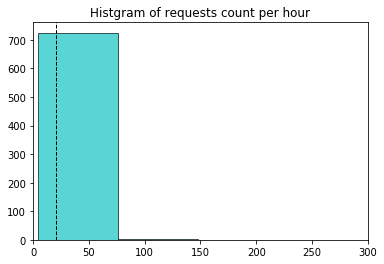

In [1049]:
#no.requests 
x = log_summary_per_ip['hits']
title = 'Histgram of requests count per hour'
HistgramGenerator(x, title, [0,300])

The histogram of request counts per hour is very askewed. The distribution of square root of request counts are less skewed and also the data is continuous by taking square root transformation.

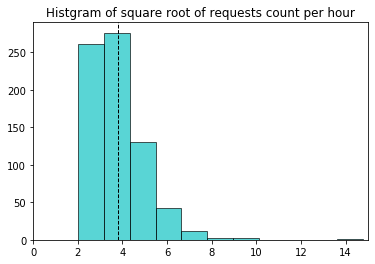

In [1053]:
#log of requests count  
x = np.sqrt(log_summary_per_ip['hits'])
title = 'Histgram of square root of requests count per hour'
HistgramGenerator(x, title, [0,15])

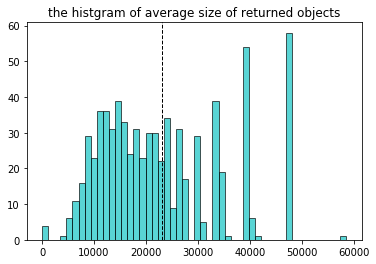

In [937]:
x =  log_summary_per_ip['avg_returned_ob']
title = 'the histgram of average size of returned objects'
HistgramGenerator(x, title)

The average returned object size is around 20,000 to 40,000. Taking a log transformation gives us more details of how the distribution looks like for IP that returned small object and the distribution gets more like gaussian  

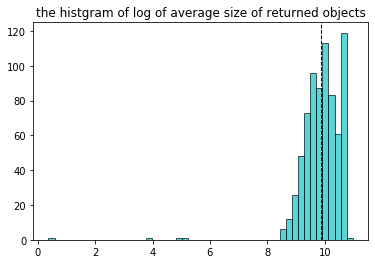

In [938]:
x =  np.log(log_summary_per_ip['avg_returned_ob'])
title = 'histgram of log of average size of returned objects'
HistgramGenerator(x, title)

Most of IPs have low bounce rate. Some of the IPs are in the tail of the histogram which suggests high bounce rate.

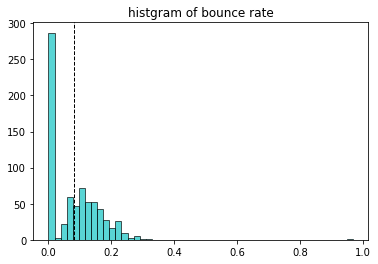

In [958]:
x = log_summary_per_ip['bounce_rate']
title = 'histgram of bounce rate'
HistgramGenerator(x, title)

Most of IPs actually waited less than an hour before sending another request.

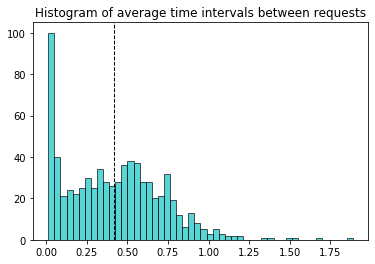

In [963]:

x = log_summary_per_ip['avg_interval']
title = 'Histogram of average time intervals between requests'
HistgramGenerator(x, title)


Interval variety ratio measures how irregular time intervals between requests are. If an IP waits exactly same amount of time before another request each time or has a strong pattern in its request behavior, the interval variety ratio would be small and vice versa. There are some IPs are close to one as the histogram shows, which might be a red flag for robots

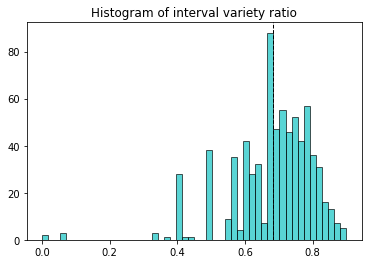

In [1055]:
x = log_summary_per_ip['interval_variety_ratio']
title = 'Histogram of interval variety ratio'
HistgramGenerator(x, title)


Taking log transformation makes the distribution more similar to gaussian distribution 

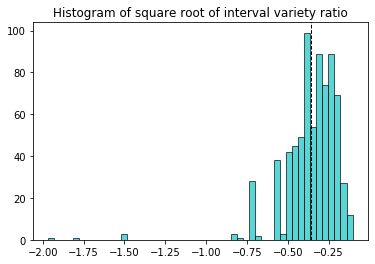

In [1056]:

x =boxcox(log_summary_per_ip['interval_variety_ratio'],0.5)
title = 'Histogram of square root of interval variety ratio'
HistgramGenerator(x, title)


### Which IPs might be robots 

#### 1. the ips made large amount of requests during the hour compared to average

In [550]:
robots = []

In [551]:
log_summary_per_ip.sort_values('hits', ascending = False).head()

ip                                           interval  \
268   176.91.204.223  [0.016666666666666666, 0.016666666666666666, 0...   
165  147.214.232.221  [0.2833333333333333, 0.2833333333333333, 0.3, ...   
351   195.36.125.153  [0.11666666666666667, 0.3, 0.18333333333333332...   
298   183.31.211.143  [0.13333333333333333, 0.03333333333333333, 1.3...   
578    59.96.237.230  [0.8666666666666667, 0.85, 0.55, 1.31666666666...   

     avg_interval    median  sd_interval  avg_returned_ob  hits  bounce_rate  \
268      0.016667  0.016667     0.000000        45.000000  3600     0.000000   
165      0.286683  0.283333     0.006695       184.114286   210     0.000000   
351      0.653498  0.316667     0.868566      4671.524390    82     0.170732   
298      0.681042  0.441667     0.779929      4758.061728    81     0.123457   
578      0.649005  0.266667     1.006393      4859.117647    68     0.161765   

     unique_no_intervals     ratio  
268                    1  0.000278  
165                    2  0.009524  
351                   50  0.609756  
298                   55  0.679012  
578                   42  0.617647

There are two suspicious IPs with high requests during the hour, with each hit returned small size of objects compared to the regular. More interesting observation is the time interval between requets are identical or followed a pattern.

Suspicious IPs are 176.91.204.223 with 3600 hits and 147.214.232.221 with 210 hits 

In [552]:
robots.append('176.91.204.223')
robots.append('147.214.232.221')

#### 2. high bounce rate, bounce rate is the number of visits without return object divided by the total hits 

The bounce rate identifies the number of IPs that leave without taking any objects. Bounce rate equals the number of requests devided by the requests with no objects returned 

In [553]:
log_summary_per_ip.sort_values('bounce_rate', ascending = False).head()

ip                                           interval  \
400   211.19.198.132  [0.9833333333333333, 0.9833333333333333, 0.983...   
162  146.231.171.114  [0.9833333333333333, 0.06666666666666667, 1.58...   
538     5.134.31.215  [1.7, 0.9666666666666667, 0.03333333333333333,...   
276  178.207.175.170  [2.0833333333333335, 0.03333333333333333, 4.21...   
592   63.177.215.115  [2.9, 0.18333333333333332, 1.1666666666666667,...   

     avg_interval    median  sd_interval  avg_returned_ob  hits  bounce_rate  \
400      0.950556  0.983333     0.179531         1.451613    31     0.967742   
162      0.505556  0.275000     0.642656     13040.473684    19     0.315789   
538      0.925439  0.200000     1.329768     12717.350000    20     0.300000   
276      0.780000  0.183333     1.227530     12819.714286    21     0.285714   
592      0.519643  0.200000     0.815060      9074.551724    29     0.275862   

     unique_no_intervals     ratio  
400                    2  0.064516  
162                   16  0.842105  
538                   16  0.800000  
276                   14  0.666667  
592                   19  0.655172

In [554]:
robots.extend(log_summary_per_ip.sort_values('bounce_rate', ascending = True).ip[0:1])

#### 3. return small objects

Another characteristics of bots is low volume of objects returned at each of requests, which is correlated with the frequent requests and hight bounce rate. Therefore those IPs that return small objects might also show high volume of requests and bounce rate.

In [555]:
log_summary_per_ip.sort_values('avg_returned_ob', ascending = True).head()

ip                                           interval  \
400   211.19.198.132  [0.9833333333333333, 0.9833333333333333, 0.983...   
268   176.91.204.223  [0.016666666666666666, 0.016666666666666666, 0...   
728   99.255.192.186  [1.0666666666666667, 1.0666666666666667, 1.083...   
165  147.214.232.221  [0.2833333333333333, 0.2833333333333333, 0.3, ...   
351   195.36.125.153  [0.11666666666666667, 0.3, 0.18333333333333332...   

     avg_interval    median  sd_interval  avg_returned_ob  hits  bounce_rate  \
400      0.950556  0.983333     0.179531         1.451613    31     0.967742   
268      0.016667  0.016667     0.000000        45.000000  3600     0.000000   
728      1.071264  1.066667     0.007581       130.600000    30     0.000000   
165      0.286683  0.283333     0.006695       184.114286   210     0.000000   
351      0.653498  0.316667     0.868566      4671.524390    82     0.170732   

     unique_no_intervals     ratio  
400                    2  0.064516  
268                    1  0.000278  
728                    2  0.066667  
165                    2  0.009524  
351                   50  0.609756

In [556]:
robots.extend(log_summary_per_ip.sort_values('avg_returned_ob', ascending = True).ip[0:4])

### Robots 

Now we obtained a list of suspicious IPs that might be robots based on *bounce rate*, *average size of objects returned per request*, *number of hits* in this hour

In [557]:
robots = list(set(robots))

In [1068]:
log_summary_per_ip[log_summary_per_ip['ip'].isin(robots)][['ip', 'avg_returned_ob', 'bounce_rate', 'interval_variety_ratio']]

ip  avg_returned_ob  bounce_rate  interval_variety_ratio
268   176.91.204.223        45.000000     0.000000                0.000278
165  147.214.232.221       184.114286     0.000000                0.009524
400   211.19.198.132         1.451613     0.967742                0.064516
728   99.255.192.186       130.600000     0.000000                0.066667

All suspicious IPs also have a strong pattern in intervals between each of two requests. The IPs waited same amount of time for another requests, for instance IP *176.91.204.223*, which waited exactly 0.017 minutes each time to send another request. Since robots are scripted, it makeas sense that they follow a strong pattern in durations between sessions.

### Bot Detector Algorithm

Two approaches will work for robot detection. 
Approach 1: 
1. Take the center of robot IPs as one cluster that represents robots 
2. take the rest of IPs as one cluster that represent normal IPs. 
3. calculate the distance of IP to each of the cluster 
4. assign the IP to the nearest cluster 

Limitations: We don't have enough data points to represent robots clusters. The center of the clusters will be very biased. Therefore we will use approach 2 instead.


Approach 2: 
1. Select the features that might take unusual large or small value in the event of robots we use to identify robots, such as constant movements, high hits and high bounce rate. Say we have features x1,x2,..x3
2. Fit a distribution to the histogram of each feature excluding the anomaly(robots). Robots tend to have features in far away from the normal behavior. Therefore, p(x) is large for normal IPs and small for robots IPs 
3. We assume features are uncorrelated, or only have low level of correlation. Calculate p(x1)*p(x2)*p(x3) for each IPs. If  p(x1)*p(x2)*p(x3)<threshold, then assign the IP as a robot.

Limitation: it's recommended to have all features transformed into guassian distribution, while the algorithm will still work for features with skewed distribution. 

Overview of how to construct gaussian distribution based on data of normal IPs


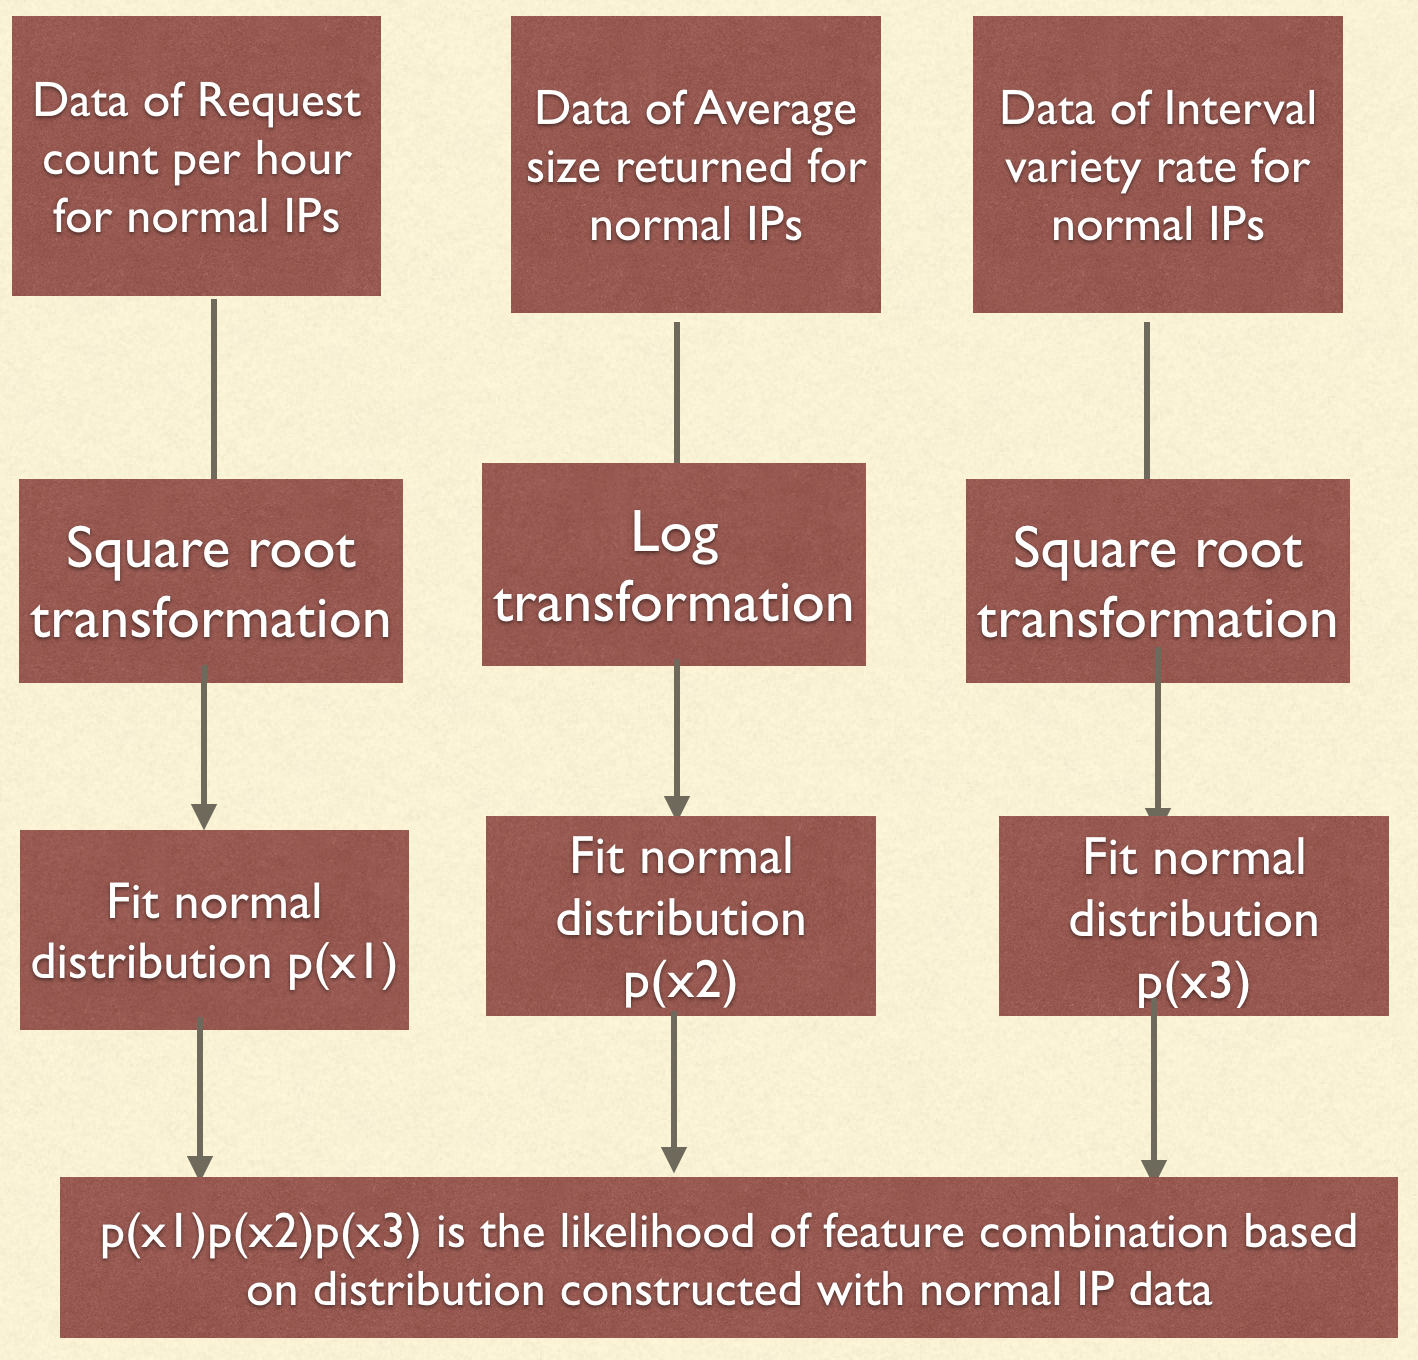

In [1114]:
print('Overview of how to construct gaussian distribution based on data of normal IPs')
IPython.display.Image("/Users/zoeyzhang/Desktop/pic2.png", width=500, height=1000)

#### Features selected for robot detection 

Supicious IPs have send more requests, and have high bounce rate, low average of the size of objects returned,  more importantly, suspicious IPs tend to wait exactly same amount of time before sending another request. There is strong pattern in the wait time between requests. Since average size of objects returned is correlated with number of requests and bounce rate. I will select 'interval_variety_ratio', 'hits', 'avg_returned_ob' as the final features

#### Features Transformation 

Transformation of features 
Features need to transform to Gaussian distribution. In the analysis above, I will take square root of requests count, log of average objects returned and square root of interval variety ratio as transformed features 

#### Fit Guassia distribution and p-value 
Fit Guassian distribution for three transformed features excluding the suspcious IP as the distribution for normal IPs. Estimate the likelihood of an IP with combinations of features displayed

In [1003]:
def get_parameters():
    """
    The goal of the function is fit Guassian distribution for three transformed features excluding the suspcious IP 
    """
    x1 = np.sqrt(log_summary_per_ip[~(log_summary_per_ip['ip'].isin(robots))]['hits'])
    x2 = np.log(log_summary_per_ip[~log_summary_per_ip['ip'].isin(robots)]['avg_returned_ob'])
    x3 = np.sqrt(log_summary_per_ip[~log_summary_per_ip['ip'].isin(robots)]['interval_variety_ratio'])
    loc_hits, scale_hits = x1.mean(), x1.std()
    loc_log_avg_returned_ob, scale_log_avg_returned_ob = x2.mean(), x2.std()
    loc_ratio, scale_ratio = x3.mean(), x3.std()
    return(loc_hits, scale_hits,loc_log_avg_returned_ob, scale_log_avg_returned_ob,loc_ratio, scale_ratio)
  
    
def LogPValue(hits, interval_variety_ratio, avg_returned_ob):
    """
    Output the log likelihood of an observation(IP) with combinations of features 
    Input:@sqrt_hits: the log of number of requests in an hour 
          @sqrt_ratio: the sqrt of ratio 
          @log_avg_returned_ob: the log of average size of returned objects per hour 
    Output: @ans: 
    """
    sqrt_hits = math.sqrt(hits)
    sqrt_ratio = math.sqrt(interval_variety_ratio)
    log_avg_returned_ob = math.log(avg_returned_ob)
    loc_hits, scale_hits,loc_log_avg_returned_ob, scale_log_avg_returned_ob,loc_ratio, scale_ratio = get_parameters()
    p1= norm.pdf(sqrt_hits, loc_hits, scale_hits)
    p2 = norm.pdf(sqrt_ratio, loc_ratio, scale_ratio)
    p3 = norm.pdf(log_avg_returned_ob, loc_log_avg_returned_ob, scale_log_avg_returned_ob)
    p = [p1,p2,p3]
    try: 
        ans = sum([math.log(i) for i in p])
    except:
        ans = -1000
    return(ans)

#### estimate p-value for observations  

In [1069]:
log_summary_per_ip['pvalue'] = log_summary_per_ip.apply(lambda row: LogPValue(row['hits'], \
                       row['interval_variety_ratio'], row['avg_returned_ob']), axis = 1)

#### p_value of suspicious IPs

In [866]:
log_summary_per_ip['pvalue'] = log_summary_per_ip[~log_summary_per_ip['ip'].isin(robots)].\
                        apply(lambda row: LogPValue(row['hits'], \
                       row['ratio'], row['avg_returned_ob']), axis = 1)

In [1124]:
log_summary_per_ip[log_summary_per_ip['ip'].isin(robots)].sort_values(['pvalue'])[['ip', 'pvalue']].head()

ip       pvalue
268   176.91.204.223 -1000.000000
400   211.19.198.132  -192.732775
165  147.214.232.221  -130.739207
728   99.255.192.186   -76.027712

#### p_value of IPs(suspicious IPs not included) 

In [1042]:
log_summary_per_ip[~log_summary_per_ip['ip'].isin(robots)].sort_values(['pvalue']).head()

ip                                           interval  \
693    90.230.14.74  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
351  195.36.125.153  [0.11666666666666667, 0.3, 0.18333333333333332...   
298  183.31.211.143  [0.13333333333333333, 0.03333333333333333, 1.3...   
578   59.96.237.230  [0.8666666666666667, 0.85, 0.55, 1.31666666666...   
532   47.205.247.79  [0.016666666666666666, 0.4666666666666667, 1.2...   

     avg_interval  sd_interval  avg_returned_ob  hits  bounce_rate  \
693      0.939394     0.242306      8735.882353    34     0.000000   
351      0.653498     0.868566      4671.524390    82     0.170732   
298      0.681042     0.779929      4758.061728    81     0.123457   
578      0.649005     1.006393      4859.117647    68     0.161765   
532      0.788611     1.161155      5448.409836    61     0.213115   

     unique_no_intervals  interval_variety_ratio     pvalue  
693                    2                0.058824 -34.434539  
351                   50                0.609756 -14.090370  
298                   55                0.679012 -13.602287  
578                   42                0.617647 -10.941708  
532                   41                0.672131  -8.877714

In [1126]:
print('describe pvalue data of normal IPs')
log_summary_per_ip[~log_summary_per_ip['ip'].isin(robots)].sort_values(['pvalue'])['pvalue'].describe()

describe pvalue data of normal IPs


count    725.000000
mean      -1.165714
std        2.122354
min      -34.434539
25%       -1.700062
50%       -0.537685
75%        0.002518
max        0.322182
Name: pvalue, dtype: float64

#### what is the threshold(significance level) for robot detector 
One last step, we need to find the threshold, if the likelihoold of vlaue of feature combinations is under the threshold, the algorithm will tag it as robots. Based on the likelihood of the suspicious IPs and normal IPs, I assign the threshold as -45. 


Overview of robot detector algorithm


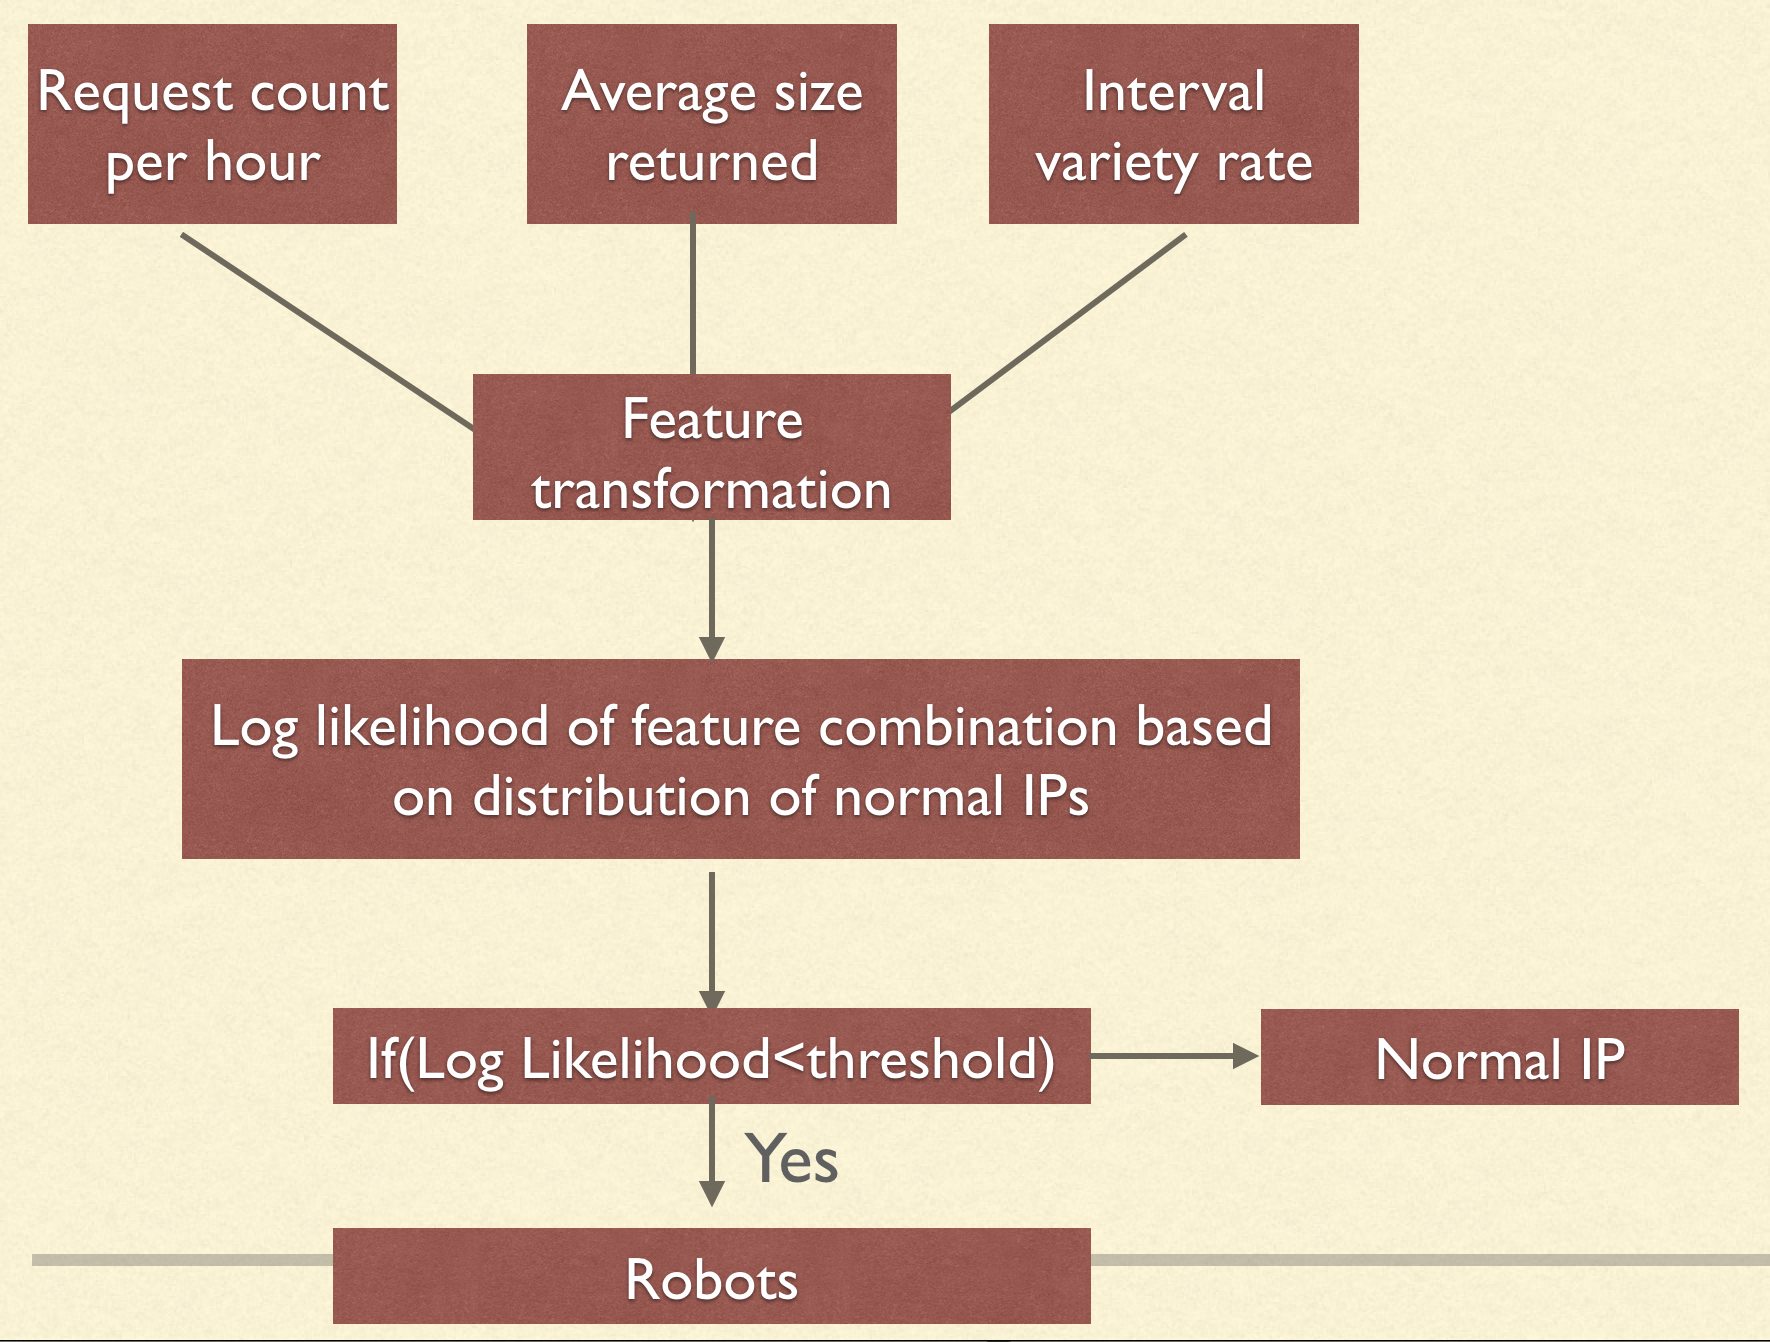

In [1112]:
print('Overview of robot detector algorithm')
IPython.display.Image("/Users/zoeyzhang/Desktop/pic1.png", width=500, height=1000)